In [1]:
# Step 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
# step 2: Load the datasets

customers = pd.read_csv(r"C:\Users\USER\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\USER\Downloads\Transactions.csv")


In [3]:
# Preview the datasets
print(customers.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [4]:
# Step 3: Data Preprocessing

# Handle Missing Values:
customers.dropna(inplace=True)
transactions.dropna(inplace=True)


In [5]:
# Merge Datasets: 
customer_transactions = pd.merge(customers, transactions, on="CustomerID")
print(customer_transactions.head())


  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  
0      P054  2024-01-19 03:12:55         2      114.60   57.30  
1      P022  2024-09-17 09:01:18         3      412.62  137.54  
2      P096  2024-04-08 00:01:00         2      614.94  307.47  
3      P083  2024-05-07 03:11:44         2      911.44  455.72  
4      P029  2024-11-02 17:04:16         3     1300.92  433.64  


In [6]:
print(customer_transactions.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TransactionID',
       'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [7]:
# Feature Engineering:

customer_summary = customer_transactions.groupby("CustomerID").agg({
    "TransactionID": "count",  # Total transactions per customer
    "ProductID": "nunique",    # Unique products purchased per customer
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={
    "TransactionID": "TransactionCount", 
    "ProductID": "UniqueProducts"
}, inplace=True)

print(customer_summary.head())


  CustomerID  TransactionCount  UniqueProducts
0      C0001                 5               5
1      C0002                 4               4
2      C0003                 4               4
3      C0004                 8               8
4      C0005                 3               3


In [8]:
# Check column names first
print(customer_transactions.columns)

# Add the 'Amount' column if necessary
if 'Amount' not in customer_transactions.columns:
    if 'Quantity' in customer_transactions.columns and 'Price' in customer_transactions.columns:
        customer_transactions['Amount'] = customer_transactions['Quantity'] * customer_transactions['Price']
    else:
        raise ValueError("Required columns ('Quantity' and 'Price') are missing to calculate 'Amount'.")

# Proceed with the aggregation
customer_summary = customer_transactions.groupby("CustomerID").agg({
    "Amount": "sum",   # Total transaction amount
    "TransactionID": "count",  # Total transactions
    "ProductID": "nunique",   # Unique products purchased
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={"Amount": "TotalAmount", "TransactionID": "TransactionCount", "ProductID": "UniqueProducts"}, inplace=True)

print(customer_summary)



Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TransactionID',
       'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price'],
      dtype='object')
    CustomerID  TotalAmount  TransactionCount  UniqueProducts
0        C0001      3354.52                 5               5
1        C0002      1862.74                 4               4
2        C0003      2725.38                 4               4
3        C0004      5354.88                 8               8
4        C0005      2034.24                 3               3
..         ...          ...               ...             ...
194      C0196      4982.88                 4               3
195      C0197      1928.65                 3               3
196      C0198       931.83                 2               2
197      C0199      1979.28                 4               4
198      C0200      4758.60                 5               5

[199 rows x 4 columns]


In [9]:
# Standardize the Data: 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_summary.iloc[:, 1:])  # Exclude CustomerID


In [27]:
# step 4: Perform Clustering

# Choose a Clustering Algorithm: For this, we use KMeans clustering.
kmeans_models = {}
db_scores = []
for k in range(2, 11):  # Testing for clusters between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    kmeans_models[k] = kmeans
    
    # Calculate Davies-Bouldin Index
    db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_scores.append((k, db_score))
    print(f"Clusters: {k}, DB Index: {db_score}")


Clusters: 2, DB Index: 0.7326724318621637
Clusters: 3, DB Index: 0.7636341768660931
Clusters: 4, DB Index: 0.9182221873822776
Clusters: 5, DB Index: 0.9245800474301245
Clusters: 6, DB Index: 0.8151985435582336
Clusters: 7, DB Index: 0.8449538978125013
Clusters: 8, DB Index: 0.854697191808881
Clusters: 9, DB Index: 0.8094221291806367
Clusters: 10, DB Index: 0.8659344328651486


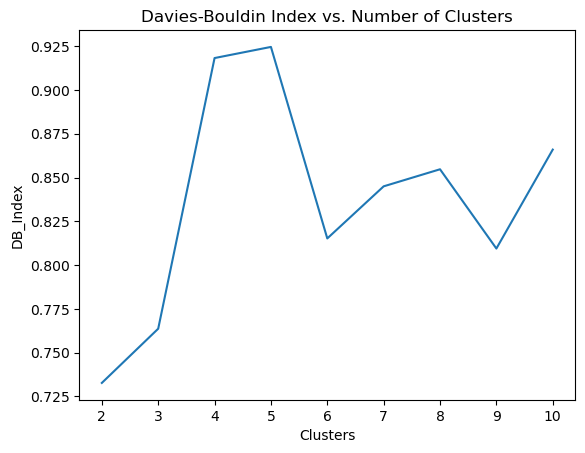

In [11]:
# Select the Optimal Number of Clusters:Visualize the Davies-Bouldin Index to determine the optimal number of clusters.

db_df = pd.DataFrame(db_scores, columns=["Clusters", "DB_Index"])
sns.lineplot(x="Clusters", y="DB_Index", data=db_df)
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.show()


In [12]:
pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Your other imports here
from sklearn.cluster import KMeans
# Rest of your code


In [14]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set the environment variable
print("OMP_NUM_THREADS is set to:", os.environ.get("OMP_NUM_THREADS"))


OMP_NUM_THREADS is set to: 1


In [25]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [16]:
# Run Clustering with Optimal k:

optimal_k = db_df.loc[db_df["DB_Index"].idxmin(), "Clusters"]
final_kmeans = kmeans_models[optimal_k]
customer_summary["Cluster"] = final_kmeans.labels_


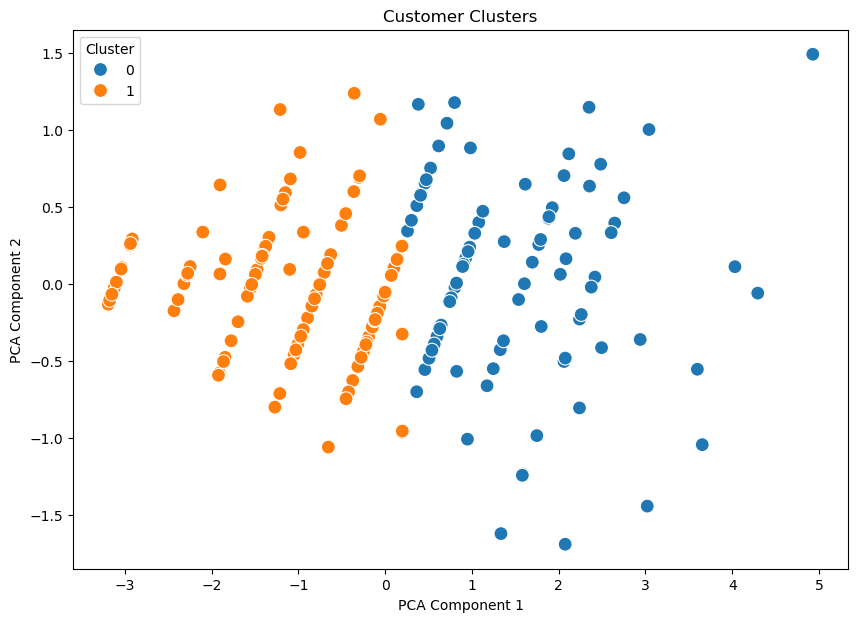

In [33]:
# step 5:  Visualize the Clusters:

# 1.Reduce Dimensions with PCA (for visualization):

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_summary["Cluster"], palette="tab10", s=100)
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [59]:
customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total number of transactions per customer
    'ProductID': 'nunique'     # Number of unique products purchased
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={
    'TransactionID': 'TransactionCount',
    'ProductID': 'UniqueProducts'
}, inplace=True)

print(customer_summary.head())


  CustomerID  TransactionCount  UniqueProducts
0      C0001                 5               5
1      C0002                 4               4
2      C0003                 4               4
3      C0004                 8               8
4      C0005                 3               3


In [63]:
features = customer_summary[['TransactionCount', 'UniqueProducts']]
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(scaled_features)

print(customer_summary.head())


  CustomerID  TransactionCount  UniqueProducts  Cluster
0      C0001                 5               5        1
1      C0002                 4               4        1
2      C0003                 4               4        1
3      C0004                 8               8        0
4      C0005                 3               3        1


In [67]:
print(customer_transactions.dtypes)


CustomerID          object
CustomerName        object
Region              object
SignupDate          object
TransactionID       object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
Amount             float64
dtype: object


In [69]:
# Convert columns to numeric if necessary
customer_transactions['TransactionID'] = pd.to_numeric(customer_transactions['TransactionID'], errors='coerce')
customer_transactions['ProductID'] = pd.to_numeric(customer_transactions['ProductID'], errors='coerce')

# Drop rows with invalid data
customer_transactions.dropna(subset=['TransactionID', 'ProductID'], inplace=True)


In [71]:
customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total transactions
    'ProductID': 'nunique'     # Unique products
}).reset_index()

# Rename columns for clarity
customer_summary.rename(columns={
    'TransactionID': 'TransactionCount',
    'ProductID': 'UniqueProducts'
}, inplace=True)

print(customer_summary.head())


Empty DataFrame
Columns: [CustomerID, TransactionCount, UniqueProducts]
Index: []


In [73]:
print(customer_summary.dtypes)


CustomerID          object
TransactionCount     int64
UniqueProducts       int64
dtype: object


In [79]:
print(customer_summary.columns)


Index(['CustomerID', 'TransactionCount', 'UniqueProducts'], dtype='object')


In [81]:
print(customer_summary[['TransactionCount', 'UniqueProducts']].isna().sum())


TransactionCount    0
UniqueProducts      0
dtype: int64


In [83]:
print(customer_summary.shape)
print(customer_summary.head())


(0, 3)
Empty DataFrame
Columns: [CustomerID, TransactionCount, UniqueProducts]
Index: []


In [85]:
features = customer_summary[['TransactionCount', 'UniqueProducts']]
print(features.shape)


(0, 2)


In [87]:
from sklearn.preprocessing import StandardScaler

if not features.empty:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
else:
    print("No data available for scaling.")


No data available for scaling.


In [89]:
# Select the required columns
features = customer_summary[['TransactionCount', 'UniqueProducts']]

# Check for missing values
print(features.isna().sum())

# Drop rows with missing values
features = features.dropna()

# Check if there is any data left
if features.empty:
    print("No data available for clustering.")
else:
    print("Data is ready for scaling and clustering.")


TransactionCount    0
UniqueProducts      0
dtype: int64
No data available for clustering.


In [91]:
print(features.dtypes)


TransactionCount    int64
UniqueProducts      int64
dtype: object


In [93]:
features['TransactionCount'] = pd.to_numeric(features['TransactionCount'], errors='coerce')
features['UniqueProducts'] = pd.to_numeric(features['UniqueProducts'], errors='coerce')


In [97]:
features.fillna(0, inplace=True)


In [99]:
features.fillna(features.mean(), inplace=True)


In [101]:
features.fillna(features.median(), inplace=True)


In [105]:
# Check for missing values
print(features.isna().sum())

# Fill missing values
features.ffill(inplace=True)  # Forward fill
features.bfill(inplace=True)  # Backward fill

# Verify no missing values remain
print(features.isna().sum())



TransactionCount    0
UniqueProducts      0
dtype: int64
TransactionCount    0
UniqueProducts      0
dtype: int64


In [107]:
# adding values to Dataframe
data = {
    'CustomerID': [1, 2, 3, 4],
    'TransactionCount': [10, 20, 15, 30],
    'UniqueProducts': [5, 7, 6, 8]
}
df = pd.DataFrame(data)

# Select features for clustering
features = df[['TransactionCount', 'UniqueProducts']]

In [109]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [111]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Example: 2 clusters
df['Cluster'] = kmeans.fit_predict(scaled_features)


In [113]:
# Check Updated DataFrame
print(df)

   CustomerID  TransactionCount  UniqueProducts  Cluster
0           1                10               5        0
1           2                20               7        0
2           3                15               6        0
3           4                30               8        1


In [117]:
# Analyze the clusters
cluster_analysis = df.groupby('Cluster').mean()
print(cluster_analysis)


         CustomerID  TransactionCount  UniqueProducts
Cluster                                              
0               2.0              15.0             6.0
1               4.0              30.0             8.0


In [119]:
# step 6: Save Results

customer_summary.to_csv("Customer_Clusters.csv", index=False)

# Save Davies-Bouldin Index for all cluster sizes
db_df.to_csv("DB_Index_Results.csv", index=False)
